In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Modelos   import *
from FuncsChern import *

import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex':    True,
    'font.family':    'serif',
    'font.serif':     ['Computer Modern'], 
    'axes.unicode_minus': False,
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

def createletters(axs, Axis3D=[], coord=[0.08, 0.92], ni=0, SMALL_SIZE=20):
    import numpy as np
    letters = [r'\textbf{(a)}', r'\textbf{(b)}', r'\textbf{(c)}', r'\textbf{(d)}', r'\textbf{(e)}', r'\textbf{(f)}',
               r'\textbf{(g)}', r'\textbf{(h)}',r'\textbf{(i)}']
    # Aplanar axs si es un array multidimensional
    axs = np.ravel(axs)
    for n, ax in enumerate(axs):
        if n in Axis3D:
            ax.text2D(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')
        else:
            ax.text(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')


[1/5] Precalculando malla k …
[2/5] Barrido panel (a)  – G vs Δ  (μ = μ₀)


<>:66: SyntaxWarning: invalid escape sequence '\s'
<>:66: SyntaxWarning: invalid escape sequence '\s'
/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_2160/1816652544.py:66: SyntaxWarning: invalid escape sequence '\s'
  """Devuelve (N_KPOINTS, 5) con los coeficientes del cuártico


G-DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[3/5] Barrido panel (b)  – μ vs Δ  (G = G₀)


mu-DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4/5] Barrido panel (c)  – μ vs G  (Δ = Δ₀)


mu-G grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4b/5]  Barrido (inset)  μ vs G  alta resolución …


mu-G grid:   0%|          | 0/160801 [00:00<?, ?it/s]

[5/5] Dibujando figura …
Listo → triple_param_scan.pdf


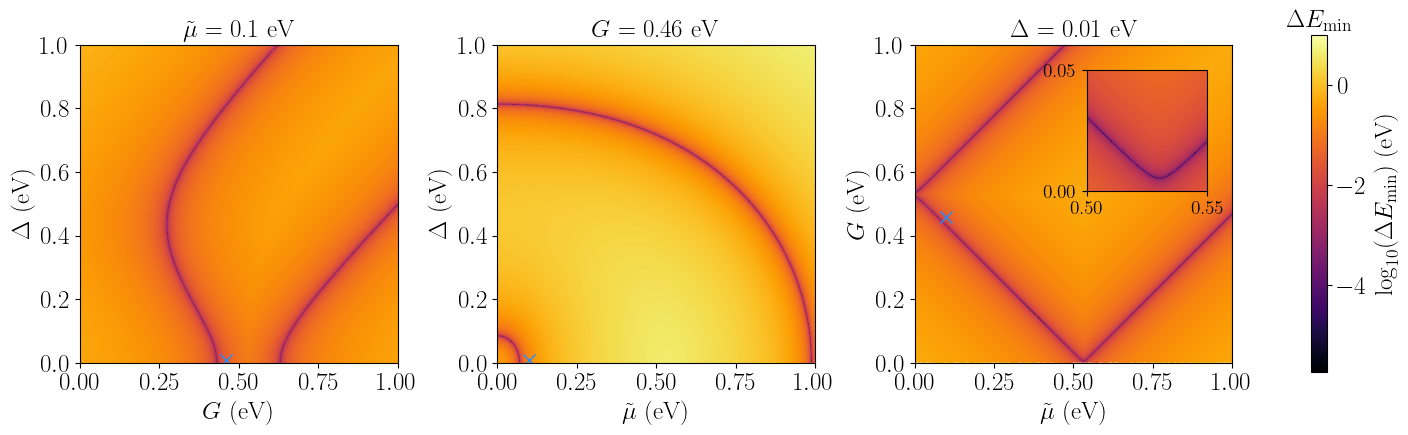

In [3]:
#!/usr/bin/env python3
"""triple_gap_scan_parallel.py – versión sin‑Numba, con malla *k* precalculada y
paralelización Joblib

  * Calcula los tres cortes (G‑Δ, μ‑Δ, μ‑G) del espacio de parámetros
    del cuártico implícito  [α(E_k)^2 − β(E_k)]² = γ(E_k)
  * Precalcula seno/coseno para toda la malla k → fuera de cualquier bucle
  * Vectoriza los coeficientes del cuártico (sin bucles Python)
  * Barre el espacio de parámetros en paralelo (todos los cores disponibles)

Dependencias:  numpy, matplotlib, joblib, tqdm  (≈ `pip install numpy matplotlib joblib tqdm`)

Ejecutar:
    python triple_gap_scan_parallel.py
Genera  *triple_param_scan.png* en el directorio actual.

Ajusta a tu gusto:
    NK           – tamaño de la malla k (≈ 60–100)
    AXIS_POINTS  – número de puntos por eje de parámetros (≈ 100–250)
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ──────────────────────────────────────────────────────────────────────
# MODELO Y CONSTANTES
# ──────────────────────────────────────────────────────────────────────
MU0, G0, DELTA0 = 0.1, 0.46, 0.01   # valores ancla (eV)
T               = 0.45              # ruptura TRS (eV)

# Discretización -------------------------------------------------------
NK = 2            # puntos por eje k  →  kx, ky  ∈ [0, π/a]
AXIS_POINTS = 501  # resolución de los ejes de parámetros (G, μ, Δ)

a_lat = 4.0        # parámetro de red *(a)* en las funciones seno/cos

# Barridos de parámetros (puedes ampliarlos) --------------------------
G_vals     = np.linspace(-0, 1.0, AXIS_POINTS)   # eV
DELTA_vals = np.linspace(-0, 1.0, AXIS_POINTS)   # eV
MU_vals    = np.linspace(-0, 1.0, AXIS_POINTS)   # eV

# ──────────────────────────────────────────────────────────────────────
# MALLA k PRECALCULADA
# ──────────────────────────────────────────────────────────────────────
print("[1/5] Precalculando malla k …")
kx_pts = np.linspace(0.0, np.pi/a_lat, NK)
ky_pts = np.linspace(0.0, np.pi/a_lat, NK)

kxg, kyg = np.meshgrid(kx_pts, ky_pts, indexing="ij")            # (Nk,Nk)
cos_kx, cos_ky = np.cos(kxg * a_lat), np.cos(kyg * a_lat)
sin_kx, sin_ky = np.sin(kxg * a_lat), np.sin(kyg * a_lat)

# Constantes de estructura (no dependen de los parámetros dinámicos) --
M_grid = -0.28 + 2*56.6 / a_lat**2 * (2.0 - cos_kx - cos_ky)        # (Nk,Nk)
A_grid =  4.1  / a_lat      * np.hypot(sin_kx, sin_ky)            # (Nk,Nk)

N_KPOINTS = NK * NK                                              # plano Brillouin discreto

# ──────────────────────────────────────────────────────────────────────
# CUÁRTICO IMPLÍCITO – COEFICIENTES VECTORIALIZADOS
# ──────────────────────────────────────────────────────────────────────

def quartic_coeffs_grid(mu: float, G: float, D: float) -> np.ndarray:
    """Devuelve (N_KPOINTS, 5) con los coeficientes del cuártico
        \sum_{n=0}^4 c_n s^{4-n}   donde  s = E²"""
    eps = mu   # traslación rígida; escalar

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 =  4*G**2 * (M_grid**2 + T**2) - 4*D**2 * (M_grid**2 + A_grid**2)
    b1 =  4 * (eps**2 + D**2)

    g0 = -64 * G**2 * T**2 * D**2 * A_grid**2
    g1 =  64 * G**2 * (eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    # Apilamos a lo largo del último eje → shape (Nk,Nk,5)
    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)          # (N_KPOINTS, 5)

# ──────────────────────────────────────────────────────────────────────
# GAP LOCAL (un único punto k)
# ──────────────────────────────────────────────────────────────────────

def local_gap_from_coeffs(c: np.ndarray, tol: float = 1e-12) -> float:
    """Mínima separación positiva entre niveles, para un polinomio dado."""
    roots = np.roots(c)
    s = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    #dif = np.diff(E)
    dif = E
    pos = dif[dif > 0.0]
    return pos.min() if pos.size else np.inf

# ──────────────────────────────────────────────────────────────────────
# GAP GLOBAL (mínimo en toda la malla k)
# ──────────────────────────────────────────────────────────────────────

def global_gap(mu: float, G: float, D: float) -> float:
    coeffs = quartic_coeffs_grid(mu, G, D)  # (N_KPOINTS,5)
    g_min = np.inf
    for c in coeffs:                        # bucle sobre k, pero sin trigonometría
        gap = local_gap_from_coeffs(c)
        if gap < g_min:
            g_min = gap
            if g_min == 0.0:
                break
    return g_min

# ──────────────────────────────────────────────────────────────────────
# BARRIDO 2‑D EN PARALELO (Joblib)
# ──────────────────────────────────────────────────────────────────────

def sweep_2D_parallel(axis1: np.ndarray, axis2: np.ndarray,
                      fixed: dict[str, float],
                      names: tuple[str, str]) -> np.ndarray:
    """Evalúa global_gap para todos los puntos (len(axis1) × len(axis2))
       usando todos los cores disponibles."""
    total = len(axis1) * len(axis2)

    def calc(idx: int) -> float:
        i = idx // len(axis2)
        j = idx %  len(axis2)
        pars = {names[0]: axis1[i], names[1]: axis2[j], **fixed}
        return global_gap(pars['mu'], pars['G'], pars['DELTA'])

    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(calc)(idx) for idx in tqdm(range(total), desc=f"{names[0]}-{names[1]} grid"))
    return np.asarray(results).reshape(len(axis1), len(axis2))

# ──────────────────────────────────────────────────────────────────────
# MAIN
# ──────────────────────────────────────────────────────────────────────

def main():
    print("[2/5] Barrido panel (a)  – G vs Δ  (μ = μ₀)")
    panel_a = sweep_2D_parallel(G_vals,     DELTA_vals,
                                fixed={'mu': MU0}, names=('G', 'DELTA'))

    print("[3/5] Barrido panel (b)  – μ vs Δ  (G = G₀)")
    panel_b = sweep_2D_parallel(MU_vals,    DELTA_vals,
                                fixed={'G':  G0}, names=('mu', 'DELTA'))

    print("[4/5] Barrido panel (c)  – μ vs G  (Δ = Δ₀)")
    panel_c = sweep_2D_parallel(MU_vals,    G_vals,
                                fixed={'DELTA': DELTA0}, names=('mu', 'G'))
    
    MU_zoom   = np.linspace(0.50, 0.55, 401)   # 400×400 puntos bastan
    G_zoom    = np.linspace(0.00, 0.05, 401)

    print("[4b/5]  Barrido (inset)  μ vs G  alta resolución …")
    panel_zoom = sweep_2D_parallel(MU_zoom, G_zoom,
                                fixed={'DELTA': DELTA0},
                                names=('mu', 'G'))
    
    clip_lo, clip_hi = 1e-8, 1e+1

    log_zoom = np.log10(np.clip(panel_zoom, clip_lo, clip_hi))

    # Log‑scale para visualizar, con clipping
    
    log_a = np.log10(np.clip(panel_a, clip_lo, clip_hi))
    log_b = np.log10(np.clip(panel_b, clip_lo, clip_hi))
    log_c = np.log10(np.clip(panel_c, clip_lo, clip_hi))

    # ─────────────────── Figura
    print("[5/5] Dibujando figura …")
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.3), constrained_layout=True)
    cmap = "inferno"
    img_a = axes[0].imshow(log_a.T, origin="lower", extent=[G_vals[0], G_vals[-1], DELTA_vals[0], DELTA_vals[-1]], cmap=cmap)
    img_b = axes[1].imshow(log_b.T, origin="lower", extent=[MU_vals[0], MU_vals[-1], DELTA_vals[0], DELTA_vals[-1]], cmap=cmap)
    img_c = axes[2].imshow(log_c.T, origin="lower", extent=[MU_vals[0], MU_vals[-1],  G_vals[0],   G_vals[-1]],   cmap=cmap)

    axes[0].set_xlabel(r'$G$ (eV)');     axes[0].set_ylabel(r'$\Delta$ (eV)');  axes[0].set_title(r'$\tilde{\mu}$ = 'f'{MU0} eV')
    axes[1].set_xlabel(r'$\tilde{\mu}$ (eV)');     axes[1].set_ylabel(r'$\Delta$ (eV)');  axes[1].set_title(r'$G$ = 'f'{G0} eV')
    axes[2].set_xlabel(r'$\tilde{\mu}$ (eV)');     axes[2].set_ylabel(r'$G$ (eV)');  axes[2].set_title(r'$\Delta$ = 'f'{DELTA0} eV')

    axes[0].plot(G0,DELTA0,c='dodgerblue',marker='x',markersize=8)

    axes[1].plot(MU0,DELTA0,c='dodgerblue',marker='x',markersize=8)

    axes[2].plot(MU0,G0,c='dodgerblue',marker='x',markersize=8)

        # ─── Zoom-in sobre μ∈[0.5,0.55], G∈[0,0.05] con datos de alta resolución
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

    axins = inset_axes(
        axes[2], width="38%", height="38%",
        loc="upper right", borderpad=1.0)

    axins.imshow(
        log_zoom.T,
        origin="lower",
        extent=[MU_zoom[0], MU_zoom[-1], G_zoom[0], G_zoom[-1]],
        cmap=cmap,
        aspect="auto",
        interpolation="nearest")   # mantiene nitidez del dato denso

    axins.set_xlim(0.50, 0.55)
    axins.set_ylim(0.00, 0.05)
    axins.set_xticks([0.50, 0.55])
    axins.set_yticks([0.00, 0.05])
    axins.tick_params(labelsize=14)

    #mark_inset(axes[2], axins, loc1=2, loc2=4,
    #        fc="none", ec="deepskyblue", lw=0.8)

    # Barra de color común
    cb = fig.colorbar(img_c, ax=axes.ravel().tolist(), shrink=0.9, label=r"$\log_{10}(\Delta E_\mathrm{min})$  (eV)")
    cb.ax.set_title(r'$\Delta E_{\min}$')

    fig.savefig("triple_param_scan.pdf", dpi=300)
    print("Listo → triple_param_scan.pdf")

    return

if __name__ == "__main__":
    main()


[1/5] Precalculando malla k …
[2/5] Barrido panel (a) – G vs Δ  (μ = μ₀)


G–DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[3/5] Barrido panel (b) – μ vs Δ  (G = G₀)


mu–DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4/5] Barrido panel (c) – μ vs G  (Δ = Δ₀)


mu–G grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4b/5]  Barrido (inset) μ vs G  alta resolución …


mu–G grid:   0%|          | 0/160801 [00:00<?, ?it/s]

[5/5] Dibujando figura …
Listo → triple_param_scan.pdf


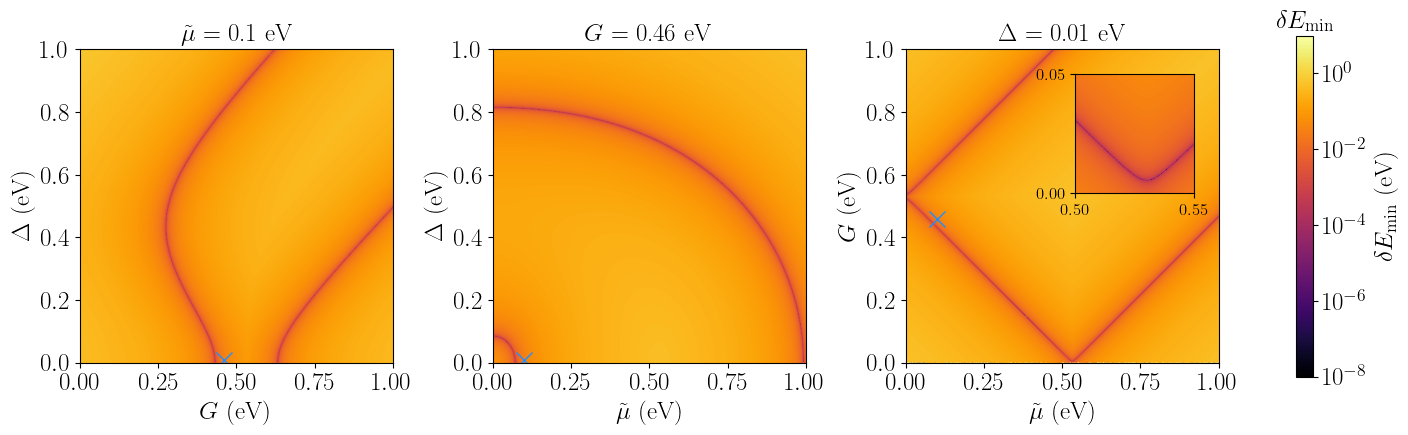

In [8]:
#!/usr/bin/env python3
"""
triple_gap_scan_parallel.py – versión sin Numba, con malla *k* precalculada y
paralelización Joblib. Representa los tres cortes (G-Δ, μ-Δ, μ-G) del espacio
de parámetros del cuártico implícito
        [α(E_k)^2 − β(E_k)]² = γ(E_k)

Ahora la escala de color es logarítmica física (LogNorm).  Genera
*triple_param_scan.pdf* en el directorio actual.
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm           # ← NUEVO
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ───────────────────────────────────────── MODELO Y CONSTANTES ─────────────────────────────────────────
MU0, G0, DELTA0 = 0.10, 0.46, 0.01     # valores ancla (eV)
T               = 0.45                 # ruptura TRS (eV)

NK           = 2           # puntos por eje k  →  kx, ky ∈ [0, π/a]
AXIS_POINTS  = 501         # resolución de los ejes de parámetros

a_lat = 4.0                # parámetro de red (Å)

G_vals     = np.linspace(0.0, 1.0, AXIS_POINTS)   # eV
DELTA_vals = np.linspace(0.0, 1.0, AXIS_POINTS)   # eV
MU_vals    = np.linspace(0.0, 1.0, AXIS_POINTS)   # eV

# Rango de la escala logarítmica para los gaps ------------------------
clip_lo, clip_hi = 1e-8, 1e+1            # eV

# ──────────────────────────────── MALLA k PRECALCULADA ────────────────────────────────
print("[1/5] Precalculando malla k …")
kx_pts = np.linspace(0.0, np.pi/a_lat, NK)
ky_pts = np.linspace(0.0, np.pi/a_lat, NK)

kxg, kyg = np.meshgrid(kx_pts, ky_pts, indexing="ij")      # (Nk,Nk)
cos_kx, cos_ky = np.cos(kxg * a_lat), np.cos(kyg * a_lat)
sin_kx, sin_ky = np.sin(kxg * a_lat), np.sin(kyg * a_lat)

M_grid = -0.28 + 2*56.6 / a_lat**2 * (2.0 - cos_kx - cos_ky)
A_grid =  4.1  / a_lat * np.hypot(sin_kx, sin_ky)

N_KPOINTS = NK * NK

# ───────────────────────────── CUÁRTICO – COEFICIENTES ─────────────────────────────
def quartic_coeffs_grid(mu: float, G: float, D: float) -> np.ndarray:
    """Devuelve (N_KPOINTS, 5) con los coeficientes del cuártico
           ∑_{n=0}^4 c_n s^{4-n},  s = E²"""
    eps = mu

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 =  4*G**2 * (M_grid**2 + T**2) - 4*D**2 * (M_grid**2 + A_grid**2)
    b1 =  4 * (eps**2 + D**2)

    g0 = -64 * G**2 * T**2 * D**2 * A_grid**2
    g1 =  64 * G**2 * (eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)

# ───────────────────────────── GAP LOCAL (un k) ─────────────────────────────
def local_gap_from_coeffs(c: np.ndarray, tol: float = 1e-12) -> float:
    """Mínima separación positiva entre niveles para un polinomio dado."""
    roots = np.roots(c)
    s = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    pos = E[E > 0.0]
    return pos.min() if pos.size else np.inf

# ───────────────────────────── GAP GLOBAL (malla completa) ─────────────────────────────
def global_gap(mu: float, G: float, D: float) -> float:
    coeffs = quartic_coeffs_grid(mu, G, D)
    g_min = np.inf
    for c in coeffs:                        # bucle sobre k, sin trigonometría
        gap = local_gap_from_coeffs(c)
        if gap < g_min:
            g_min = gap
            if g_min == 0.0:
                break
    return g_min

# ───────────────────────────── BARRIDO 2-D EN PARALELO ─────────────────────────────
def sweep_2D_parallel(axis1: np.ndarray, axis2: np.ndarray,
                      fixed: dict[str, float],
                      names: tuple[str, str]) -> np.ndarray:
    total = len(axis1) * len(axis2)

    def calc(idx: int) -> float:
        i = idx // len(axis2)
        j = idx %  len(axis2)
        pars = {names[0]: axis1[i], names[1]: axis2[j], **fixed}
        return global_gap(pars['mu'], pars['G'], pars['DELTA'])

    results = Parallel(n_jobs=-1)(
        delayed(calc)(idx) for idx in tqdm(range(total), desc=f"{names[0]}–{names[1]} grid"))
    return np.asarray(results).reshape(len(axis1), len(axis2))

# ───────────────────────────── MAIN ─────────────────────────────
def main():
    print("[2/5] Barrido panel (a) – G vs Δ  (μ = μ₀)")
    panel_a = sweep_2D_parallel(G_vals, DELTA_vals,
                                fixed={'mu': MU0}, names=('G', 'DELTA'))

    print("[3/5] Barrido panel (b) – μ vs Δ  (G = G₀)")
    panel_b = sweep_2D_parallel(MU_vals, DELTA_vals,
                                fixed={'G': G0}, names=('mu', 'DELTA'))

    print("[4/5] Barrido panel (c) – μ vs G  (Δ = Δ₀)")
    panel_c = sweep_2D_parallel(MU_vals, G_vals,
                                fixed={'DELTA': DELTA0}, names=('mu', 'G'))

    # ───────── Zoom (alta resolución)
    MU_zoom = np.linspace(0.50, 0.55, 401)
    G_zoom  = np.linspace(0.00, 0.05, 401)
    print("[4b/5]  Barrido (inset) μ vs G  alta resolución …")
    panel_zoom = sweep_2D_parallel(MU_zoom, G_zoom,
                                   fixed={'DELTA': DELTA0},
                                   names=('mu', 'G'))

    # ───────── Figura
    print("[5/5] Dibujando figura …")
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.3), constrained_layout=True)
    cmap = "inferno"
    norm = LogNorm(vmin=clip_lo, vmax=clip_hi)

    img_a = axes[0].imshow(panel_a.T, origin="lower",
                           extent=[G_vals[0], G_vals[-1],
                                   DELTA_vals[0], DELTA_vals[-1]],
                           cmap=cmap, norm=norm)
    img_b = axes[1].imshow(panel_b.T, origin="lower",
                           extent=[MU_vals[0], MU_vals[-1],
                                   DELTA_vals[0], DELTA_vals[-1]],
                           cmap=cmap, norm=norm)
    img_c = axes[2].imshow(panel_c.T, origin="lower",
                           extent=[MU_vals[0], MU_vals[-1],
                                   G_vals[0],   G_vals[-1]],
                           cmap=cmap, norm=norm)

    # Etiquetas y títulos ------------------------------------------------
    axes[0].set_xlabel(r'$G$ (eV)');     axes[0].set_ylabel(r'$\Delta$ (eV)');  axes[0].set_title(r'$\tilde{\mu}$ = 'f'{MU0} eV')
    axes[1].set_xlabel(r'$\tilde{\mu}$ (eV)');     axes[1].set_ylabel(r'$\Delta$ (eV)');  axes[1].set_title(r'$G$ = 'f'{G0} eV')
    axes[2].set_xlabel(r'$\tilde{\mu}$ (eV)');     axes[2].set_ylabel(r'$G$ (eV)');  axes[2].set_title(r'$\Delta$ = 'f'{DELTA0} eV')
    

    # Cruces azules ------------------------------------------------------
    axes[0].plot(G0,      DELTA0, c='dodgerblue', marker='x', markersize=12)
    axes[1].plot(MU0,     DELTA0, c='dodgerblue', marker='x', markersize=12)
    axes[2].plot(MU0,     G0,     c='dodgerblue', marker='x', markersize=12)

    # ─── Inset con zoom μ∈[0.5,0.55], G∈[0,0.05] (alta resolución)
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(axes[2], width="38%", height="38%",
                       loc="upper right", borderpad=1.0)

    axins.imshow(panel_zoom.T, origin="lower",
                 extent=[MU_zoom[0], MU_zoom[-1],
                         G_zoom[0],   G_zoom[-1]],
                 cmap=cmap, norm=norm,
                 interpolation="nearest", aspect="auto")

    axins.set_xlim(0.50, 0.55)
    axins.set_ylim(0.00, 0.05)
    axins.set_xticks([0.50, 0.55])
    axins.set_yticks([0.00, 0.05])
    axins.tick_params(labelsize=12)

    # Barra de color común (logarítmica) ---------------------------------
    cb = fig.colorbar(img_c, ax=axes.ravel().tolist(),
                      shrink=0.9,
                      label=r'$\delta E_{\min}$ (eV)')
    cb.ax.set_title(r'$\delta E_{\min}$')

    fig.savefig("triple_param_scan.pdf", dpi=300)
    print("Listo → triple_param_scan.pdf")

if __name__ == "__main__":
    main()

[1/6] Pre-computing (kx,ky) mesh …
[2/6] Sweeping Δ–kz plane  (μ=μ₀, G=G₀)


kz–DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[3/6] Sweeping G–kz plane  (μ=μ₀, Δ=Δ₀)


kz–G grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4/6] Plotting …
[5/6] Saved →  gap_vs_kz.pdf
[6/6] Done.


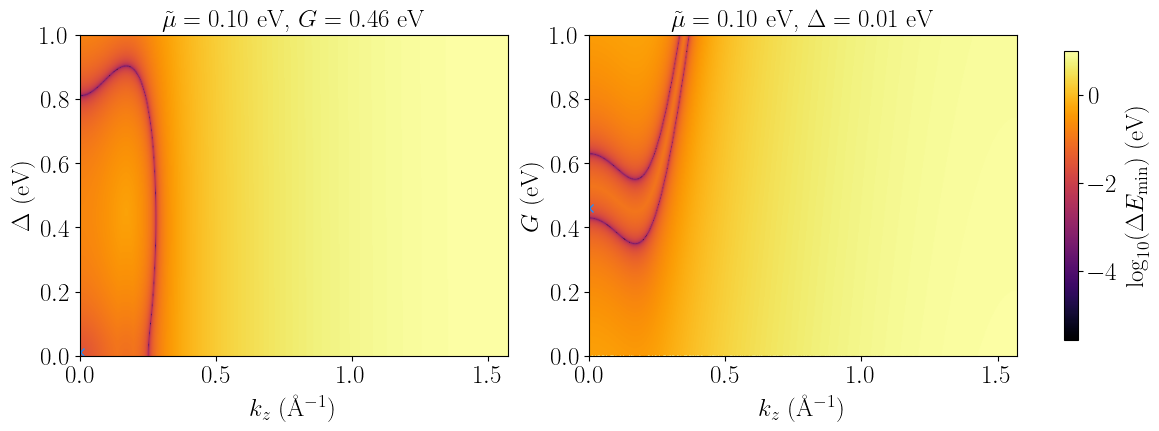

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""gap_vs_kz.py  –  2-D gap scans (Δ,kz) and (G,kz) including a quadratic
    M1 kz² mass term.  Vectorised & parallel (Joblib).

Execute:
    python gap_vs_kz.py
Creates:
    gap_vs_kz.pdf   (two-panel figure)

Dependencies: numpy, matplotlib, joblib, tqdm
"""
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ───────────────────────────────────────────────────────
# CONSTANTS & FIXED PARAMETERS
# ───────────────────────────────────────────────────────
MU0, G0, DELTA0 = 0.10, 0.46, 0.01   # anchor point (eV)
T               = 0.45               # inversion-breaking hopping (eV)
M1              = 10.0               # quadratic kz mass coefficient (eV)
c_lat           = 2.0                # lattice spacing along z  (Å)

# Discretisation -------------------------------------------------------
NK =  2              # kx,ky points (2 is enough for gap map)
AXIS_POINTS = 501    # resolution along swept axes

a_lat = 4.0          # in-plane lattice constant (Å)

# Swept axes -----------------------------------------------------------
kz_vals    = np.linspace(0.0, np.pi/c_lat, AXIS_POINTS)      # 0 … π/c
DELTA_vals = np.linspace(0.0, 1.0, AXIS_POINTS)
G_vals     = np.linspace(0.0, 1.0, AXIS_POINTS)

# ───────────────────────────────────────────────────────
# PRECOMPUTE  kx,ky  MESH
# ───────────────────────────────────────────────────────
print("[1/6] Pre-computing (kx,ky) mesh …")
kx = np.linspace(0.0, np.pi/a_lat, NK)
ky = np.linspace(0.0, np.pi/a_lat, NK)
kxg, kyg = np.meshgrid(kx, ky, indexing="ij")

cos_kx, cos_ky = np.cos(kxg * a_lat), np.cos(kyg * a_lat)
sin_kx, sin_ky = np.sin(kxg * a_lat), np.sin(kyg * a_lat)

# kx,ky-dependent pieces (fixed for the whole run) ---------------------
M_grid_xy = -0.28 + 2*56.6/a_lat**2 * (2.0 - cos_kx - cos_ky)   # (Nk,Nk)
A_grid    =  4.1 / a_lat * np.hypot(sin_kx, sin_ky)             # (Nk,Nk)
N_KPOINTS = NK * NK

# ───────────────────────────────────────────────────────
# QUARTIC COEFFICIENTS (vectorised, kx,ky grid)
# ───────────────────────────────────────────────────────
def quartic_coeffs_grid(mu: float, G: float, D: float,
                        kz: float) -> np.ndarray:
    """Return array (N_KPOINTS,5) with quartic coefficients
       Σ_{n=0}^4 c_n s^{4-n},  where  s = E²."""
    eps = mu
    # kz-dependent mass shift
    M1_term = 2*M1 / c_lat**2 * (1.0 - np.cos(kz * c_lat))
    M_grid  = M_grid_xy + M1_term      # broadcast over (Nk,Nk)

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 = 4*G**2 * (M_grid**2 + T**2) - 4*D**2 * (M_grid**2 + A_grid**2)
    b1 = 4*(eps**2 + D**2)

    g0 = -64*G**2*T**2*D**2 * A_grid**2
    g1 =  64*G**2*(eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)      # (N_KPOINTS,5)

# ───────────────────────────────────────────────────────
# LOCAL & GLOBAL GAPS
# ───────────────────────────────────────────────────────
def local_gap_from_coeffs(c: np.ndarray,
                          tol: float = 1e-12) -> float:
    roots = np.roots(c)
    s = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    return np.abs(E).min()   # min positive level spacing

def global_gap(mu: float, G: float, D: float,
               kz: float) -> float:
    coeffs = quartic_coeffs_grid(mu, G, D, kz)
    g_min = np.inf
    for c in coeffs:               # iterate over kx,ky (fast; vectorised algebra)
        gap = local_gap_from_coeffs(c)
        if gap < g_min:
            g_min = gap
            if g_min == 0.0:
                break
    return g_min

# ───────────────────────────────────────────────────────
# 2-D PARAMETER SWEEP (parallel over CPU cores)
# ───────────────────────────────────────────────────────
def sweep_2D_parallel(axis1: np.ndarray, axis2: np.ndarray,
                      fixed: dict[str,float],
                      names: tuple[str, str]) -> np.ndarray:
    """Evaluate `global_gap` on a len(axis1) × len(axis2) grid."""
    total = len(axis1) * len(axis2)

    def calc(idx: int) -> float:
        i = idx // len(axis2)
        j = idx %  len(axis2)
        pars = {names[0]: axis1[i], names[1]: axis2[j], **fixed}
        return global_gap(pars['mu'], pars['G'], pars['DELTA'], pars['kz'])

    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(calc)(idx) for idx in tqdm(range(total),
                                           desc=f"{names[0]}–{names[1]} grid"))
    return np.asarray(results).reshape(len(axis1), len(axis2))

# ───────────────────────────────────────────────────────
# WRAPPER FOR kz SCANS
# ───────────────────────────────────────────────────────
def make_panel_kz(axis_param: np.ndarray,
                  fixed_D: float | None,
                  fixed_G: float | None,
                  label_param: str):
    """Return gap map vs kz and either Δ or G."""
    if label_param == 'DELTA':
        panel = sweep_2D_parallel(kz_vals, axis_param,
                                  fixed={'mu': MU0,
                                         'G':  G0,
                                         'DELTA': 0.0,   # overwritten below
                                         'kz': 0.0},     # overwritten below
                                  names=('kz', 'DELTA'))
    else:
        panel = sweep_2D_parallel(kz_vals, axis_param,
                                  fixed={'mu': MU0,
                                         'G': 0.0,       # overwritten
                                         'DELTA': DELTA0,
                                         'kz': 0.0},
                                  names=('kz', 'G'))
    return panel

# ───────────────────────────────────────────────────────
# MAIN
# ───────────────────────────────────────────────────────
def main():
    # Panel (a): Δ vs kz  ..............................................
    print("[2/6] Sweeping Δ–kz plane  (μ=μ₀, G=G₀)")
    panel_D_kz = sweep_2D_parallel(
        kz_vals, DELTA_vals,
        fixed={'mu': MU0, 'G': G0},   # kz overwritten
        names=('kz', 'DELTA'))

    # Panel (b): G vs kz  ..............................................
    print("[3/6] Sweeping G–kz plane  (μ=μ₀, Δ=Δ₀)")
    panel_G_kz = sweep_2D_parallel(
        kz_vals, G_vals,
        fixed={'mu': MU0, 'DELTA': DELTA0},  # ¡sin 'kz'!
        names=('kz', 'G'))

    # ───────────── Plotting
    print("[4/6] Plotting …")
    clip_lo, clip_hi = 1e-8, 1e+1
    log_Dkz = np.log10(np.clip(panel_D_kz, clip_lo, clip_hi))
    log_Gkz = np.log10(np.clip(panel_G_kz, clip_lo, clip_hi))

    fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.2), constrained_layout=True)
    cmap = "inferno"

    im0 = axes[0].imshow(log_Dkz.T, origin="lower",
                         extent=[kz_vals[0], kz_vals[-1],
                                 DELTA_vals[0], DELTA_vals[-1]],
                         aspect="auto", cmap=cmap)
    axes[0].set_xlabel(r"$k_z$ (Å$^{-1}$)")
    axes[0].set_ylabel(r"$\Delta$ (eV)")
    axes[0].set_title(r"$\tilde\mu = %.2f$ eV,  $G = %.2f$ eV" % (MU0, G0))
    axes[0].plot(0.0, DELTA0, marker='x', c='dodgerblue')

    im1 = axes[1].imshow(log_Gkz.T, origin="lower",
                         extent=[kz_vals[0], kz_vals[-1],
                                 G_vals[0],  G_vals[-1]],
                         aspect="auto", cmap=cmap)
    axes[1].set_xlabel(r"$k_z$ (Å$^{-1}$)")
    axes[1].set_ylabel(r"$G$ (eV)")
    axes[1].set_title(r"$\tilde\mu = %.2f$ eV,  $\Delta = %.2f$ eV" % (MU0, DELTA0))
    axes[1].plot(0.0, G0, marker='x', c='dodgerblue')

    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.9,
                        label=r"$\log_{10}\bigl(\Delta E_\mathrm{min}\bigr)$  (eV)")

    fig.savefig("gap_vs_kz.pdf", dpi=300)
    print("[5/6] Saved →  gap_vs_kz.pdf")
    print("[6/6] Done.")

if __name__ == "__main__":
    main()